# Comparison of Clustring Algorithms

When I studying Python, this is a homework for me to analyze the performance of these two clustering methods on various subsets of our county-level cancer risk data set in the USA.

In particular, we will compare these two clustering methods in three areas:

**Efficiency** - Which method computes clusterings more efficiently?

**Automation** - Which method requires less human supervision to generate reasonable clusterings?

**Quality** - Which method generates clusterings with less error?

**The methods of clustering and related information are showed below**
![cluster_1](img\cluster_1.png)
![cluster_2](img\cluster_2.png)
![cluster_3](img\cluster_3.png)
![cluster_4](img\cluster_4.png)

**The content below is my answer to this project task.**

# My Work

First, here is a Class Cluster to store the different clusters we generate.

In [1]:
"""
Cluster class for Module 3
"""

import math


class Cluster:
    """
    Class for creating and merging clusters of counties
    """

    def __init__(self, fips_codes, horiz_pos, vert_pos, population, risk):
        """
        Create a cluster based the models a set of counties' data
        """
        self._fips_codes = fips_codes
        self._horiz_center = horiz_pos
        self._vert_center = vert_pos
        self._total_population = population
        self._averaged_risk = risk

    def __repr__(self):
        """
        String representation assuming the module is "alg_cluster".
        """
        rep = "Cluster("
        rep += str(self._fips_codes) + ", "
        rep += str(self._horiz_center) + ", "
        rep += str(self._vert_center) + ", "
        rep += str(self._total_population) + ", "
        rep += str(self._averaged_risk) + ")"
        return rep

    def fips_codes(self):
        """
        Get the cluster's set of FIPS codes
        """
        return self._fips_codes

    def horiz_center(self):
        """
        Get the averged horizontal center of cluster
        """
        return self._horiz_center

    def vert_center(self):
        """
        Get the averaged vertical center of the cluster
        """
        return self._vert_center

    def total_population(self):
        """
        Get the total population for the cluster
        """
        return self._total_population

    def averaged_risk(self):
        """
        Get the averaged risk for the cluster
        """
        return self._averaged_risk

    def copy(self):
        """
        Return a copy of a cluster
        """
        copy_cluster = Cluster(set(self._fips_codes), self._horiz_center, self._vert_center,
                               self._total_population, self._averaged_risk)
        return copy_cluster

    def distance(self, other_cluster):
        """
        Compute the Euclidean distance between two clusters
        """
        vert_dist = self._vert_center - other_cluster.vert_center()
        horiz_dist = self._horiz_center - other_cluster.horiz_center()
        return math.sqrt(vert_dist ** 2 + horiz_dist ** 2)

    def merge_clusters(self, other_cluster):
        """
        Merge one cluster into another
        The merge uses the relatively populations of each
        cluster in computing a new center and risk

        Note that this method mutates self
        """
        if len(other_cluster.fips_codes()) == 0:
            return self
        else:
            self._fips_codes.update(set(other_cluster.fips_codes()))

            # compute weights for averaging
            self_weight = float(self._total_population)
            other_weight = float(other_cluster.total_population())
            self._total_population = self._total_population + other_cluster.total_population()
            self_weight /= self._total_population
            other_weight /= self._total_population

            # update center and risk using weights
            self._vert_center = self_weight * self._vert_center + other_weight * other_cluster.vert_center()
            self._horiz_center = self_weight * self._horiz_center + other_weight * other_cluster.horiz_center()
            self._averaged_risk = self_weight * self._averaged_risk + other_weight * other_cluster.averaged_risk()
            return self

    def cluster_error(self, data_table):
        """
        Input: data_table is the original table of cancer data used in creating the cluster.

        Output: The error as the sum of the square of the distance from each county
        in the cluster to the cluster center (weighted by its population)
        """
        # Build hash table to accelerate error computation
        fips_to_line = {}
        for line_idx in range(len(data_table)):
            line = data_table[line_idx]
            fips_to_line[line[0]] = line_idx

        # compute error as weighted squared distance from counties to cluster center
        total_error = 0
        counties = self.fips_codes()
        for county in counties:
            line = data_table[fips_to_line[county]]
            singleton_cluster = Cluster(set([line[0]]), line[1], line[2], line[3], line[4])
            singleton_distance = self.distance(singleton_cluster)
            total_error += (singleton_distance ** 2) * singleton_cluster.total_population()
        return total_error

Then I apply **2 closest-pair methods** and **2 clustering mathod**

In [2]:
"""
We will implement five functions:

slow_closest_pair(cluster_list)
fast_closest_pair(cluster_list)
closest_pair_strip(cluster_list, horiz_center, half_width)
hierarchical_clustering(cluster_list, num_clusters)
kmeans_clustering(cluster_list, num_clusters, num_iterations)

where cluster_list is a 2D list of clusters in the plane
"""


######################################################
# Code for closest pairs of clusters

def min_pair(pair_a, pair_b):
    """
    get the min distance pair
    """
    if pair_a[0] <= pair_b[0]:
        return pair_a
    return pair_b


def slow_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (slow)

    Input: cluster_list is the list of clusters

    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.
    """
    min_dis = float('inf')
    closest_pair = (min_dis, 0, 0)
    for cluster in cluster_list:
        index_c = cluster_list.index(cluster)
        for other_cluster in cluster_list[cluster_list.index(cluster) + 1:]:
            dis = cluster.distance(other_cluster)
            if dis < closest_pair[0]:
                closest_pair = (dis, index_c, cluster_list.index(other_cluster))

    return closest_pair


def closest_pair_strip(cluster_list, horiz_center, half_width):
    """
    Helper function to compute the closest pair of clusters in a vertical strip

    Input: cluster_list is a list of clusters produced by fast_closest_pair
    horiz_center is the horizontal position of the strip's vertical center line
    half_width is the half the width of the strip (i.e; the maximum horizontal distance
    that a cluster can lie from the center line)

    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] lie in the strip and have minimum distance dist.
    """
    # don't go out of [horiz_l, horiz_r]
    cluster_list_m = []
    horiz_l = max(cluster_list[0].horiz_center(), horiz_center - half_width)
    horiz_r = min(cluster_list[-1].horiz_center(), horiz_center + half_width)
    # horiz_l = horiz_center - half_width
    # horiz_r = horiz_center + half_width
    for cluster in cluster_list:
        if horiz_l <= cluster.horiz_center() <= horiz_r:
            cluster_list_m.append(cluster)

    closest_pair = (float('inf'), -1, -1)
    cluster_list_m.sort(key=lambda clstr: clstr.vert_center())
    lenth = len(cluster_list_m)
    for index_i in range(lenth - 1):
        for index_j in range(index_i + 1, min(index_i + 4, lenth)):
            dis = cluster_list_m[index_i].distance(cluster_list_m[index_j])
            real_index_i = cluster_list.index(cluster_list_m[index_i])
            real_index_j = cluster_list.index(cluster_list_m[index_j])
            closest_pair = min_pair(closest_pair, (dis, min(real_index_i, real_index_j),
                                                   max(real_index_i, real_index_j)))

    return closest_pair


def fast_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (fast)

    Input: cluster_list is list of clusters SORTED such that horizontal positions of their
    centers are in ascending order

    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.
    """
    # print(cluster_list)
    if len(cluster_list) < 2:
        return float('inf'), -1, -1
    if len(cluster_list) == 2:
        return cluster_list[0].distance(cluster_list[1]), 0, 1

    mid_num = len(cluster_list) // 2
    closest_pair_l = fast_closest_pair(cluster_list[:mid_num])
    closest_pair_r = fast_closest_pair(cluster_list[mid_num:])
    closest_pair_r = (closest_pair_r[0], closest_pair_r[1] + mid_num, closest_pair_r[2] + mid_num)
    closest_pair = min_pair(closest_pair_l, closest_pair_r)

    mid_horiz = (cluster_list[mid_num - 1].horiz_center() + cluster_list[mid_num].horiz_center()) / 2
    closest_pair = min_pair(closest_pair, closest_pair_strip(cluster_list, mid_horiz, closest_pair[0]))

    return closest_pair


######################################################################
# Code for hierarchical clustering


def hierarchical_clustering(cluster_list, num_clusters):
    """
    Compute a hierarchical clustering of a set of clusters
    Note: the function may mutate cluster_list

    Input: List of clusters, integer number of clusters
    Output: List of clusters whose length is num_clusters
    """
    cluster_list_copy = []
    for cluster in cluster_list:
        cluster_list_copy.append(cluster.copy())
    cluster_list_copy.sort(key=lambda clstr: clstr.horiz_center())
    while len(cluster_list_copy) > num_clusters:
        closest_pair = fast_closest_pair(cluster_list_copy)
        cluster_list_copy[closest_pair[1]].merge_clusters(cluster_list_copy[closest_pair[2]])

        cluster_t = cluster_list_copy[closest_pair[1]]
        cluster_list_copy.remove(cluster_list_copy[closest_pair[2]])
        cluster_list_copy.remove(cluster_list_copy[closest_pair[1]])
        insert_index = -1
        for cluster in cluster_list_copy[closest_pair[1]:]:
            if cluster_t.horiz_center() < cluster.horiz_center():
                insert_index = cluster_list_copy.index(cluster)
                break
        if insert_index == -1:
            cluster_list_copy.append(cluster_t)
        else:
            cluster_list_copy.insert(insert_index, cluster_t)
    return cluster_list_copy


######################################################################
# Code for k-means clustering


def deep_copy(cluster):
    """
    deepcopy written by myself, not from importing copy module
    """
    fips_codes = set(cluster.fips_codes())
    horiz_center = cluster.horiz_center()
    vert_center = cluster.vert_center()
    population = cluster.total_population()
    risk = cluster.averaged_risk()
    return Cluster(fips_codes, horiz_center, vert_center, population, risk)


def kmeans_clustering(cluster_list, num_clusters, num_iterations):
    """
    Compute the k-means clustering of a set of clusters
    Note: the function may not mutate cluster_list

    Input: List of clusters, integers number of clusters and number of iterations
    Output: List of clusters whose length is num_clusters
    """

    # position initial clusters at the location of clusters with largest populations
    cluster_list_copy = []
    for cluster in cluster_list:
        cluster_list_copy.append(cluster.copy())
    cluster_list_copy.sort(key=lambda clstr: clstr.total_population(), reverse=True)
    cluster_list_ans = []
    for index in range(num_clusters):
        cluster_list_ans.append(cluster_list_copy[index])
    for _ in range(num_iterations):
        cluster_list_ans_after = []
        for index in range(num_clusters):
            cluster_list_ans_after.append(Cluster(set([]), 0.0, 0.0, 0.0, 0.0))

        for cluster in cluster_list_copy:
            chose_num = -1
            min_dis = float('inf')
            for center in cluster_list_ans:
                dis = center.distance(cluster)
                if dis < min_dis:
                    min_dis = dis
                    chose_num = cluster_list_ans.index(center)
            cluster_list_ans_after[chose_num].merge_clusters(cluster)

        for index in range(num_clusters):
            cluster_list_ans[index] = deep_copy(cluster_list_ans_after[index])

    return cluster_list_ans


In [3]:
# Test Data

LIST_A = [Cluster({'1'}, 0.05, 0.11, 1, 0),
          Cluster({'2'}, 0.26, 0.92, 1, 0),
          Cluster({'3'}, 0.34, 0.57, 1, 0),
          Cluster({'4'}, 0.35, 0.15, 1, 0),
          Cluster({'5'}, 0.6, 0.41, 1, 0),
          Cluster({'6'}, 0.89, 0.28, 1, 0)]

print(slow_closest_pair(LIST_A))
print(fast_closest_pair(LIST_A))
print(hierarchical_clustering(LIST_A, 2))
print(kmeans_clustering(LIST_A, 2, 4))

(0.3026549190084311, 0, 3)
(0.3026549190084311, 0, 3)
[Cluster({'2'}, 0.26, 0.92, 1, 0), Cluster({'4', '3', '5', '1', '6'}, 0.44599999999999995, 0.304, 5, 0.0)]
[Cluster({'4', '1', '5', '6'}, 0.4724999999999999, 0.2375, 4.0, 0.0), Cluster({'3', '2'}, 0.30000000000000004, 0.745, 2.0, 0.0)]


Then to answer the Question related to these methods.

**Question 1**: How about the different **time efficiency** of fast_closest_pair and slow_closest_pair?

The **slow_closest_pair**: O(n^2)

The **fast_closest_pair** use binary search and T(n) = 2T(n/2) + O(n) and T(2) = T(1) = O(1). Therefore, the time efficiency of fast_closest_pair is O(nlogn)

And I generated random data to confirm this conclusion as below.

In [4]:
 %matplotlib inline 

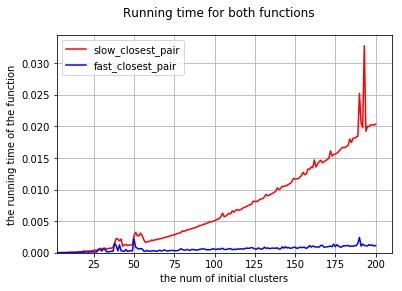

In [5]:
"""
Time efficency of fast_closest_pair and slow_closest_pair?
"""

import time
import random
import matplotlib.pyplot as plt


def gen_random_clusters(num_clusters):
    random_clusters = []
    for _ in range(num_clusters):
        horiz_center = random.random() * 2 - 1
        vert_center = random.random() * 2 - 1
        random_clusters.append(Cluster(set([]), horiz_center, vert_center, 1.0, 0))
    # print(random_clusters)
    return random_clusters


def gen_time():
    slow_time = []
    fast_time = []
    for num in range(2, 201):
        random_clusters = gen_random_clusters(num)

        start = time.clock()
        slow_closest_pair(random_clusters)
        slow_time.append(time.clock() - start)

        start = time.clock()
        fast_closest_pair(random_clusters)
        fast_time.append(time.clock() - start)

    return slow_time, fast_time


def draw_plot():
    slow_time, fast_time = gen_time()
    plt.plot(list(range(2, 201)), slow_time, '-r', label="slow_closest_pair")
    plt.plot(list(range(2, 201)), fast_time, '-b', label="fast_closest_pair")
    plt.xlabel("the num of initial clusters")
    plt.ylabel("the running time of the function")
    plt.suptitle("Running time for both functions")
    plt.grid()
    plt.xlim(2)
    plt.ylim(0)
    plt.legend(loc="upper left")
    plt.show()


draw_plot()

Then to visualize the clusters

In [24]:
"""
Some provided code for plotting the clusters using matplotlib
"""

import math
import matplotlib.pyplot as plt

# URLS for various important datasets
DIRECTORY = "http://commondatastorage.googleapis.com/codeskulptor-assets/"
MAP_URL = DIRECTORY + "data_clustering/USA_Counties.png"

# Define colors for clusters.  Display a max of 16 clusters.
COLORS = ['Aqua', 'Yellow', 'Blue', 'Fuchsia', 'Black', 'Green', 'Lime', 'Maroon', 'Navy', 'Olive', 'Orange', 'Purple',
          'Red', 'Brown', 'Teal']


# Helper functions

def circle_area(pop):
    """
    Compute area of circle proportional to population
    """
    return math.pi * pop / (200.0 ** 2)


def plot_clusters(data_table, cluster_list, draw_centers=False):
    """
    Create a plot of clusters of counties
    """

    fips_to_line = {}
    for line_idx in range(len(data_table)):
        fips_to_line[data_table[line_idx][0]] = line_idx

    # Load map image
    map_img = plt.imread('USA_Counties.png')

    # Scale plot to get size similar to CodeSkulptor version
    ypixels, xpixels, bands = map_img.shape
    DPI = 60.0  # adjust this constant to resize your plot
    xinch = xpixels / DPI
    yinch = ypixels / DPI
    fig = plt.figure(figsize=(xinch, yinch))
    implot = plt.imshow(map_img)

    # draw the counties colored by cluster on the map
    if not draw_centers:
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            for fips_code in cluster.fips_codes():
                line = data_table[fips_to_line[fips_code]]
                plt.scatter(x=[line[1]], y=[line[2]], s=circle_area(line[3]), lw=1,
                            facecolors=cluster_color, edgecolors=cluster_color)

    # add cluster centers and lines from center to counties
    else:
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            for fips_code in cluster.fips_codes():
                line = data_table[fips_to_line[fips_code]]
                plt.scatter(x=[line[1]], y=[line[2]], s=circle_area(line[3]), lw=1,
                            facecolors=cluster_color, edgecolors=cluster_color, zorder=1)
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            cluster_center = (cluster.horiz_center(), cluster.vert_center())
            for fips_code in cluster.fips_codes():
                line = data_table[fips_to_line[fips_code]]
                plt.plot([cluster_center[0], line[1]], [cluster_center[1], line[2]], cluster_color, lw=1, zorder=2)
        for cluster_idx in range(len(cluster_list)):
            cluster = cluster_list[cluster_idx]
            cluster_color = COLORS[cluster_idx % len(COLORS)]
            cluster_center = (cluster.horiz_center(), cluster.vert_center())
            cluster_pop = cluster.total_population()
            plt.scatter(x=[cluster_center[0]], y=[cluster_center[1]], s=circle_area(cluster_pop), lw=2,
                        facecolors="none", edgecolors="black", zorder=3)

    fig.savefig('ppt1.png', ppi=1000)
    return plt.figure()

In [11]:
"""
Example code for creating and visualizing
cluster of county-based cancer risk data
"""

import math
import urllib.request as urllib2
import csv


###################################################
# Code to load data tables

# URLs for cancer risk data tables of various sizes
# Numbers indicate number of counties in data table

DATA_3108_URL = open('unifiedCancerData_3108.csv');
DATA_896_URL = open('unifiedCancerData_896.csv');
DATA_290_URL = open('unifiedCancerData_290.csv');
DATA_111_URL = open('unifiedCancerData_111.csv');


def load_data_table(data_url):
    """
    Import a table of county-based cancer risk data
    from a csv format file
    """
    data_file = urllib2.urlopen(data_url)
    data = data_file.read()
    data_lines = data.split('\n')
    print("Loaded", len(data_lines), "data points")
    data_tokens = [line.split(',') for line in data_lines]
    return [[tokens[0], float(tokens[1]), float(tokens[2]), int(tokens[3]), float(tokens[4])]
            for tokens in data_tokens]


load 3108 cancer data

In [12]:
dataReader = csv.reader(DATA_3108_URL)
dataData = list(dataReader)
for line in range(len(dataData)):
    dataData[line][0] = str(dataData[line][0])
    dataData[line][1] = float(dataData[line][1])
    dataData[line][2] = float(dataData[line][2])
    dataData[line][3] = int(dataData[line][3])
    dataData[line][4] = float(dataData[line][4])

data_table = dataData

singleton_list = []
for line in data_table:
    singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))

singleton_list.sort(key=lambda clstr: clstr.horiz_center())

compute a list of clusters and plot a list of clusters by **hierarchical clustering method** (Using minutes of time)

Displaying 15 hierarchical clusters


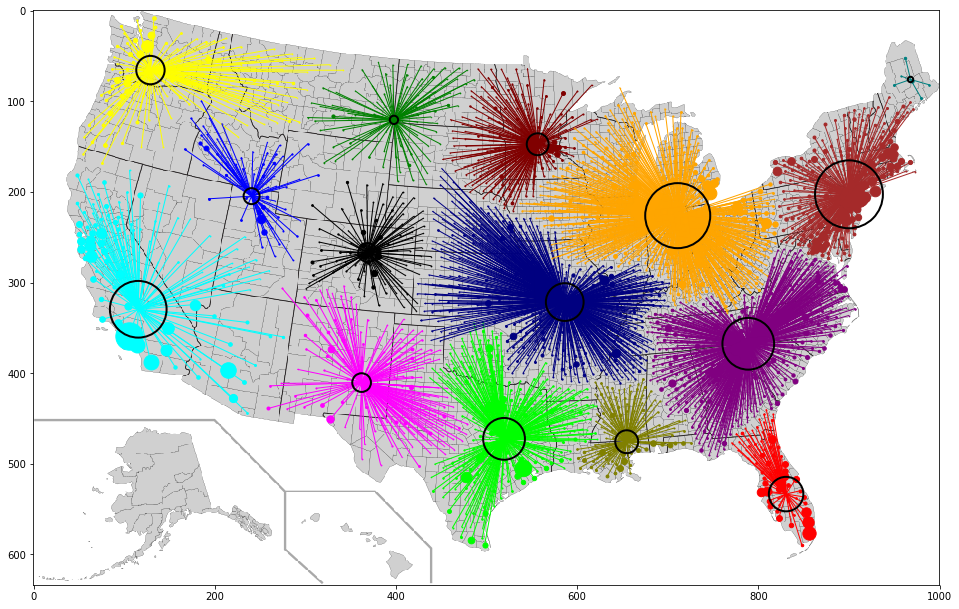

In [20]:
cluster_list = hierarchical_clustering(singleton_list, 15)
print("Displaying", len(cluster_list), "hierarchical clusters")    
# plot_clusters(data_table, cluster_list, False)
plot_clusters(data_table, cluster_list, True)  #add cluster centers

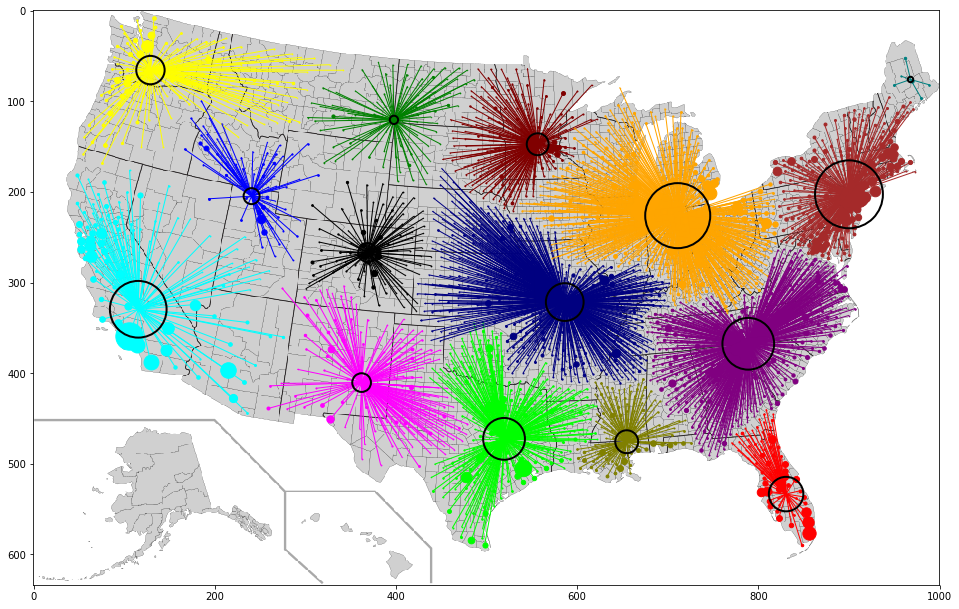

In [25]:
plot_clusters(data_table, cluster_list, True)  #add cluster centers

Displaying 1 hierarchical clusters


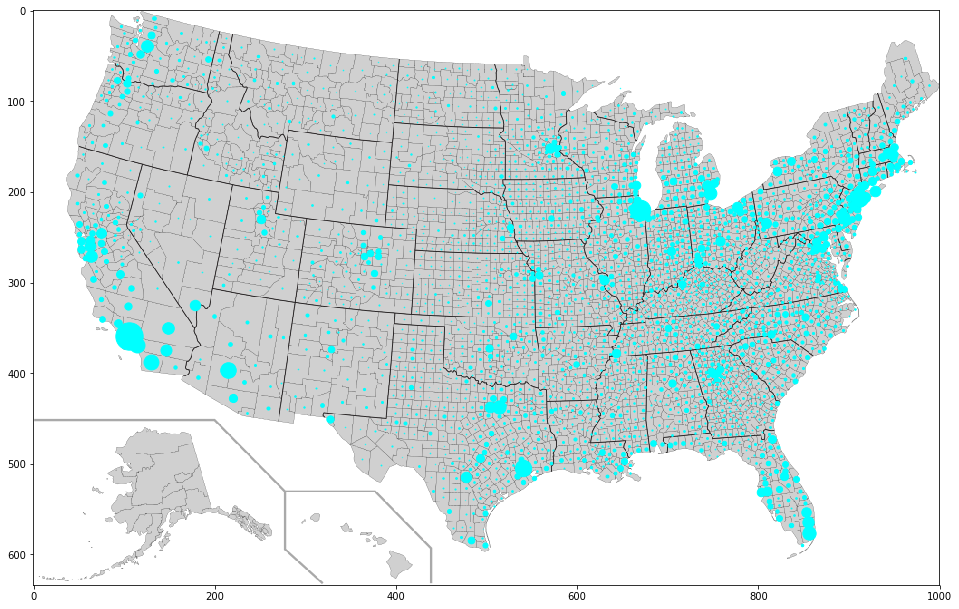

In [26]:
cluster_list = hierarchical_clustering(singleton_list, 1)
print("Displaying", len(cluster_list), "hierarchical clusters")    
plot_clusters(data_table, cluster_list, False)
# plot_clusters(data_table, cluster_list, True)  #add cluster centers

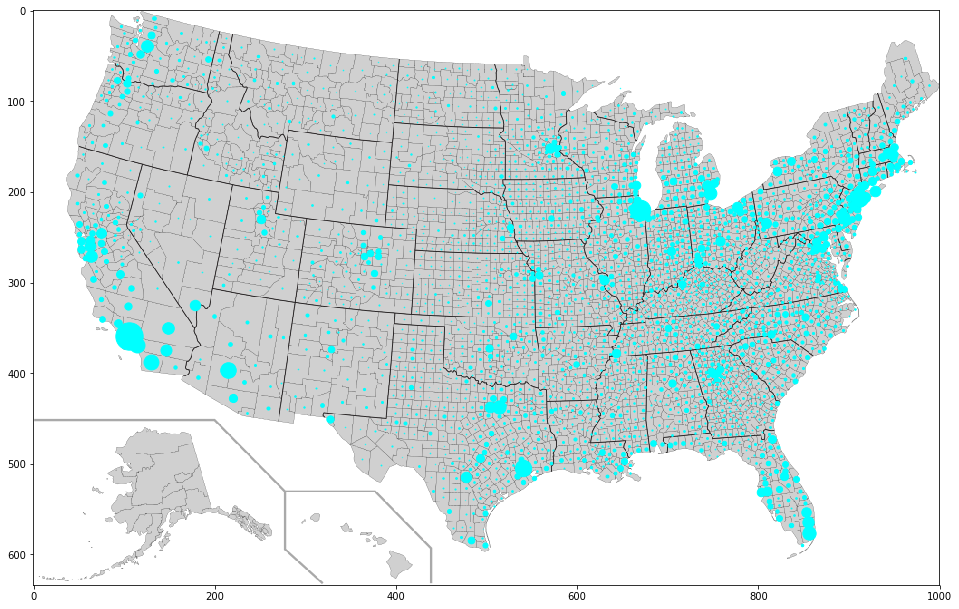

In [27]:
plot_clusters(data_table, cluster_list, False)  #add cluster centers

Displaying 15 hierarchical clusters


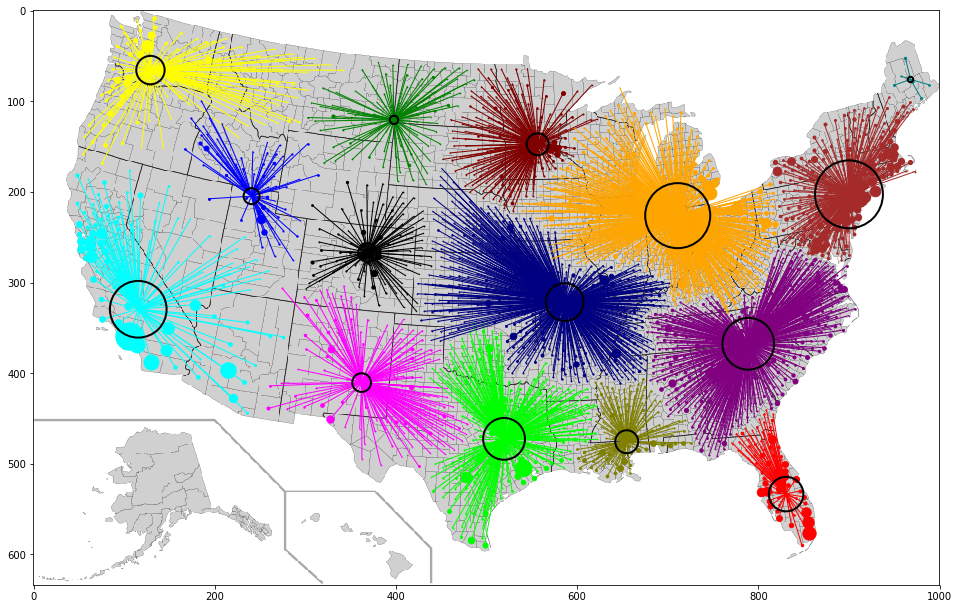

In [9]:
cluster_list = hierarchical_clustering(singleton_list, 15)
print("Displaying", len(cluster_list), "hierarchical clusters")    
# plot_clusters(data_table, cluster_list, False)
plot_clusters(data_table, cluster_list, True)  #add cluster centers

compute a list of clusters and plot a list of clusters by **k-means clustering method**

Displaying 15 k-means clusters


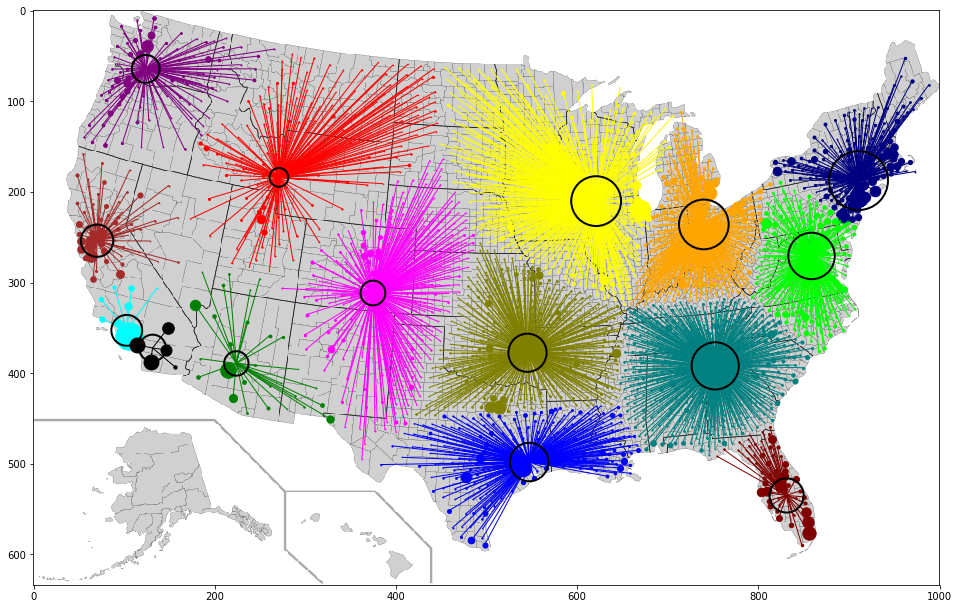

In [10]:
cluster_list = kmeans_clustering(singleton_list, 15, 5)
print("Displaying", len(cluster_list), "k-means clusters")
# plot_clusters(data_table, cluster_list, False)
plot_clusters(data_table, cluster_list, True)  #add cluster centers

To compare the time efficiency of 2 clustering method:

Suppose the number of counties is **n**, the number of clusters output is **m**

The running time of **the hierarchical method is O((n^2)*log(n))**

and the running time  of **the k means method is O(nm) and 0<m≤n.**

So hierarchical method is much slower than other one.

Let's confirm this conclusion (Use 111 data set).

In [11]:
dataReader = csv.reader(DATA_111_URL)
dataData = list(dataReader)
for line in range(len(dataData)):
    dataData[line][0] = str(dataData[line][0])
    dataData[line][1] = float(dataData[line][1])
    dataData[line][2] = float(dataData[line][2])
    dataData[line][3] = int(dataData[line][3])
    dataData[line][4] = float(dataData[line][4])

data_table = dataData

singleton_list = []
for line in data_table:
    singleton_list.append(Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))

singleton_list.sort(key=lambda clstr: clstr.horiz_center())

In [12]:
%%timeit -n 100
cluster_list = hierarchical_clustering(singleton_list, 9)

163 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit -n 100
cluster_list = kmeans_clustering(singleton_list, 9, 5)

16.3 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Question 2**: Which clustering method is with less error and requires less supervision from human?

Let's use 111 data set

Displaying 9 hierarchical clusters


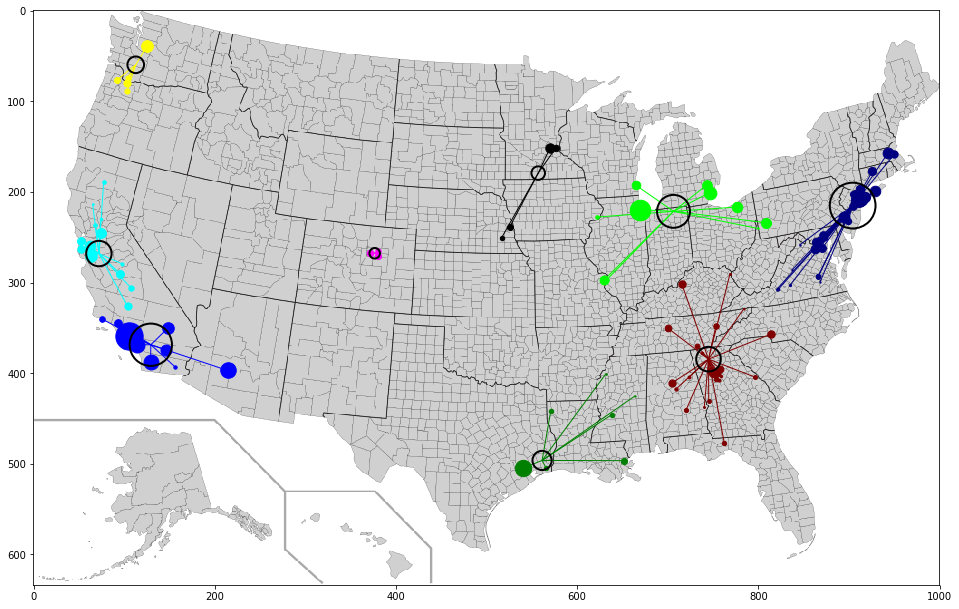

In [14]:
cluster_list = hierarchical_clustering(singleton_list, 9)
print("Displaying", len(cluster_list), "hierarchical clusters")    
# plot_clusters(data_table, cluster_list, False)
plot_clusters(data_table, cluster_list, True)  #add cluster centers

Displaying 9 k-means clusters


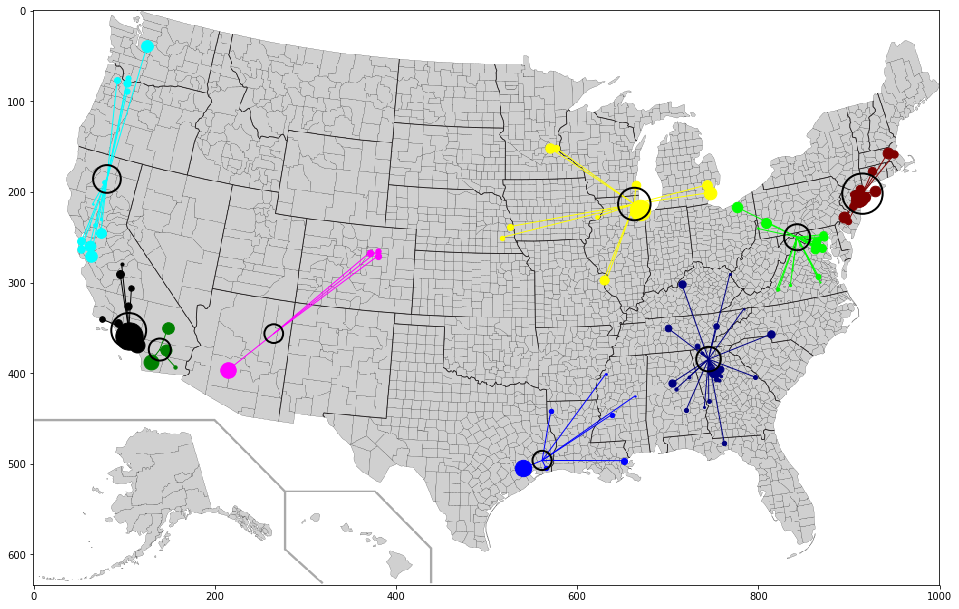

In [15]:
cluster_list = kmeans_clustering(singleton_list, 9, 5)
print("Displaying", len(cluster_list), "k-means clusters")
# plot_clusters(data_table, cluster_list, False)
plot_clusters(data_table, cluster_list, True)  #add cluster centers

As we can seen, in the graph k-means method generated, the purple cluster and blue cluster in the left is **worse** than the counterpart in the graph that hierarchical method generated. (some points are too far to each other and it is better not to cluster them togather)

Why this happened? This is because k-means method chooses counties have largest population initially and, unluckily, some counties which are great choices to be a center just have small population. 

**Question 3**: Is hierarchical method always more precise than k-means method?

One way to make this concept more precise is to formulate a mathematical measure of the error associated with a cluster. Given a cluster C, itserror is the sum of the squares of the distances from each county in the cluster to the cluster's center, weighted by each county's population. If pi is the position of the county and wi is its population, the cluster's error is:

![formula_1](img\formula_1.png)

where c is the center of the cluster C. The Cluster class includes a method cluster_error(data_table) that takes a Cluster object and the original data table associated with the counties in the cluster and computes the error associated with a given cluster.

Given a list of clusters L, the distortion of the clustering is the sum of the errors associated with its clusters.

![formula_2](img\formula_2.png)

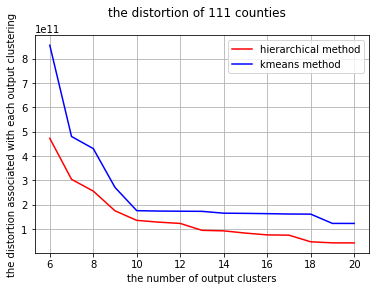

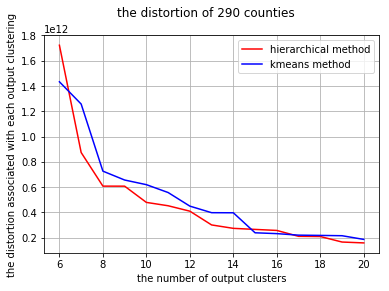

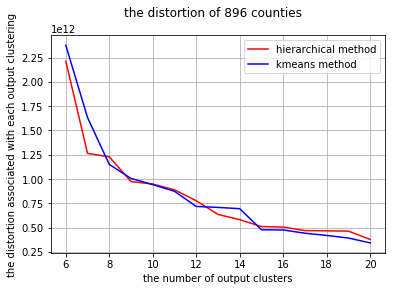

In [16]:
"""
compute distortion
"""

import matplotlib.pyplot as plt
import csv

DATA_TABLE = []
DATA_URL = ['unifiedCancerData_111.csv',
            'unifiedCancerData_290.csv',
            'unifiedCancerData_896.csv']

for index in range(3):
    with open(DATA_URL[index]) as datafile:
        database = csv.reader(datafile)
        data_table = []
        for row in database:
            data_table.append([row[0], float(row[1]), float(row[2]), int(row[3]), float(row[4])])
        DATA_TABLE.append(data_table)


def read_data(data_num):
    cluster_list = []
    for row in DATA_TABLE[data_num]:
        cluster_list.append(Cluster(set([row[0]]), row[1], row[2], row[3], row[4]))

    cluster_list.sort(key=lambda clstr: clstr.horiz_center())
    return cluster_list


def compute_distortion(cluster_list, data_table):
    distortion = 0
    for cluster in cluster_list:
        distortion += cluster.cluster_error(data_table)
    return distortion

def run_example():
    cluster_lists = []
    for idx in range(3):
        cluster_lists.append(read_data(idx))

        # hierarchical method
        cluster_list_pre = cluster_lists[idx]
        hierarchical_distortion = []
        for num_clusters in range(20, 5, -1):
            cluster_list_pre = hierarchical_clustering(cluster_list_pre, num_clusters)
            hierarchical_distortion.append(compute_distortion(cluster_list_pre, DATA_TABLE[idx]))
        hierarchical_distortion.reverse()

        # kmeans method
        kmeans_distortion = []
        for num_clusters in range(6, 21):
            kmeans_distortion.append(compute_distortion(kmeans_clustering(cluster_lists[idx], num_clusters, 5),
                                                        DATA_TABLE[idx]))

        # plot
        plt.plot(list(range(6, 21)), hierarchical_distortion, '-r', label='hierarchical method')
        plt.plot(list(range(6, 21)), kmeans_distortion, '-b', label='kmeans method')
        plt.xlabel('the number of output clusters')
        plt.ylabel('the distortion associated with each output clustering')
        plt.suptitle('the distortion of ' + DATA_URL[idx][18:21] + ' counties')
        plt.grid()
        plt.legend(loc="upper right")
        plt.savefig(str(idx))
        plt.show()


run_example()

So **only in 111 county data set**, hierarchical method consistently produce lower distortion, which means hierarchical method is precise only in 111 data set.

# Conclustion

For time efficienty: k-means method is O(nm),0<m<=n; hierarchical method is O(n^2*logn). The k-means method is much more efficient to cluster counties.

However, hierarchical method is more precise to cluster counties than k-means one when the data is not large.

Therefore, we'd better use hierarchical method when we process data below 200 sets, and use k-means method to process larger data.